<a href="https://colab.research.google.com/github/anastasia-evil/TFGCodigo/blob/master/avgT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import xlrd
from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from shutil import copyfile
from google.colab import drive
import os, sys
import glob
import random
import numpy.random as npr
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
drive.mount('/content/drive/')
path = '/content/drive/My Drive/TFG'
xlsx_files = glob.glob(os.path.join(path, '*.xlsx'))

Mounted at /content/drive/


In [ ]:
def estandarizar_columnas(df, scaler=None):
    columnas_excluidas = ['Label']
    columnas_estandarizar = [col for col in df.columns if col not in columnas_excluidas]
    if scaler is None:
        scaler = StandardScaler()
        df.loc[:, columnas_estandarizar] = scaler.fit_transform(df[columnas_estandarizar])
    else:
        df.loc[:, columnas_estandarizar] = scaler.transform(df[columnas_estandarizar])
    return df, scaler

def sliding_window_np(df, window_size, step):
    num_windows = (df.shape[0] - window_size) // step + 1
    if num_windows <= 0:
        return []

    windows = []
    for i in range(num_windows):
        start = i * step
        end = start + window_size
        window = df.iloc[start:end, :].copy()  # Asegurarse de que la ventana tenga exactamente 'window_size' filas
        if window['Label'].nunique() == 1:
            windows.append(window)
    return windows

def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot_labels[i, label - 1] = 1
    return one_hot_labels

def windows_to_tensors(windows, num_classes):
    tensors = []
    for window in windows:
        features = window.iloc[:, :-1].values
        label = window.iloc[0, -1] - 1  # Restar 1 para que sea índice 0-based
        features_tensor = torch.tensor(features, dtype=torch.float32)
        labels_tensor = torch.tensor(one_hot_encode([label], num_classes), dtype=torch.float32).squeeze()
        tensors.append((features_tensor, labels_tensor))
    return tensors

In [ ]:
def process_excel(df):
    # Verificar si el DataFrame tiene las columnas necesarias
    required_columns = ["Index", "Time", "Respiration", "Accelerometer", "EDA", "Label"]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"El DataFrame no tiene las columnas necesarias: {missing_columns}")

    # Eliminar las columnas no deseadas
    columnas_a_eliminar = ["Index", "Time", "Respiration", "Accelerometer", "EDA"]
    df = df.drop(columns=columnas_a_eliminar).copy()

    # Duplicar la primera columna y la antepenúltima columna
    df.insert(len(df.columns) - 1, 'Neck_EMG_2', df.iloc[:, 0].copy())
    df.insert(0, 'ECG_2', df.iloc[:, -3].copy())

    # Ajustar etiquetas
    ultimo_valor_no_cero = 0
    for indice, fila in df[::-1].iterrows():
        if fila['Label'] != 0:
            ultimo_valor_no_cero = fila['Label']
        else:
            df.loc[indice, 'Label'] = ultimo_valor_no_cero

    # Eliminar filas después del último valor no cero en 'Label'
    ultimo_valor_no_cero = df.loc[df['Label'] != 0, 'Label'].iloc[-1]
    indice_ultimo_no_cero = df.loc[df['Label'] == ultimo_valor_no_cero].index[-1]
    df = df.iloc[:indice_ultimo_no_cero + 1].copy()

    # Estandarizar columnas
    df, _ = estandarizar_columnas(df)

    # Crear ventanas
    win_size = 300
    stp = 150
    ventanas = sliding_window_np(df, win_size, stp)

    return ventanas


In [ ]:
all_windows = []
num_classes = 7
scaler = None

for file in xlsx_files:
    df = pd.read_excel(file)
    try:
        ventanas = process_excel(df)
        tensor_data = windows_to_tensors(ventanas, num_classes)
        all_windows.extend(tensor_data)
    except ValueError as e:
        print(f"Error al procesar {file}: {e}")

print("EL numero de ventanas es: ", len(all_windows))
if all_windows:
    print("El numero de filas y columnas de cada ventana es: ", all_windows[0][0].shape)


EL numero de ventanas es:  12071
El numero de filas y columnas de cada ventana es:  torch.Size([300, 5])


In [ ]:
class CustomDataLoader_4D(DataLoader):
    def __init__(self, dataset, batch_size, shuffle, add_channel_dim=True):
        super().__init__(dataset, batch_size, shuffle)
        self.add_channel_dim = add_channel_dim

    def __iter__(self):
        for batch in super().__iter__():
            if self.add_channel_dim:
                batch = self.add_channel_dimension(batch)
            yield batch

    def add_channel_dimension(self, batch):
        data, labels = batch
        data = data.unsqueeze(1)  # Agregar una dimensión de canal
        return data, labels


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [ ]:
# Transformación de ruido gaussiano
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import KFold
class GaussianNoiseTransform:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

gaussian_transform = GaussianNoiseTransform(mean=0.0, std=0.1)

###############################################################################################################################################
0
#fijamos la semilla del generador aleatorio para que siempre se divida igual
generator = torch.Generator().manual_seed(42)

from torch.utils.data import random_split
print(len(tensor_data))
# Calcula el tamaño para el conjunto combinado de entrenamiento y validación
train_val_size = int(0.8 * len(all_windows))  # Supongamos que queremos el 80% para entrenamiento y validación combinados
test_val_size = len(all_windows) - train_val_size

# Divide el conjunto de datos en entrenamiento + validación y prueba
trainset, testset = random_split(all_windows, [train_val_size, test_val_size], generator = generator)
batch_size = 64
trainset = CustomDataset(trainset, transform=gaussian_transform)
trainloader = CustomDataLoader_4D(trainset, batch_size, shuffle=True)
testloader = CustomDataLoader_4D(testset, batch_size, shuffle=False)
#valloader = CustomDataLoader_4D(valset, batch_size, shuffle=False)


# Verificar la forma del primer lote de datos
for batch_data, batch_labels in trainloader:
    print("Dimensiones del lote de datos:", batch_data.shape)
    print("Dimensiones del lote de etiquetas:", batch_labels.shape)
    break  # Detener después de imprimir el primer lote.

36
Dimensiones del lote de datos: torch.Size([64, 1, 300, 5])
Dimensiones del lote de etiquetas: torch.Size([64, 7])


In [ ]:
import torch
from collections import Counter

# Función para contar las etiquetas en un conjunto de datos
def contar_etiquetas(dataset):
    etiquetas_contador = Counter()
    for _, labels in dataset:
        etiqueta = torch.argmax(labels).item()  # Obtener la etiqueta como un entero
        etiquetas_contador[etiqueta] += 1
    return etiquetas_contador

# Contar las etiquetas en el conjunto de entrenamiento
etiquetas_entrenamiento = contar_etiquetas(trainset)
print("Conteo de etiquetas en el conjunto de entrenamiento:")
for etiqueta, conteo in etiquetas_entrenamiento.items():
    print(f"Etiqueta {etiqueta}: {conteo} veces")

# Contar las etiquetas en el conjunto de prueba
etiquetas_prueba = contar_etiquetas(testset)
print("\nConteo de etiquetas en el conjunto de prueba:")
for etiqueta, conteo in etiquetas_prueba.items():
    print(f"Etiqueta {etiqueta}: {conteo} veces")

Conteo de etiquetas en el conjunto de entrenamiento:
Etiqueta 4: 969 veces
Etiqueta 2: 2277 veces
Etiqueta 1: 2184 veces
Etiqueta 0: 1791 veces
Etiqueta 6: 743 veces
Etiqueta 3: 1547 veces
Etiqueta 5: 145 veces

Conteo de etiquetas en el conjunto de prueba:
Etiqueta 2: 553 veces
Etiqueta 3: 383 veces
Etiqueta 1: 564 veces
Etiqueta 6: 157 veces
Etiqueta 0: 445 veces
Etiqueta 5: 33 veces
Etiqueta 4: 280 veces


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        # Bloque #1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Bloque #2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Bloque #3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

        # Bloque #4
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(3, stride=(2, 1), padding=1)
        self.avr = nn.AdaptiveAvgPool2d((1,5))
        self.conv1x1 = nn.Conv2d(5,1,1)
        self.bn1d1 = nn.BatchNorm1d(1024)
        self.bn1d2 = nn.BatchNorm1d(512)

        # Ajustar la dimensión de entrada de la capa fully connected
        self.fc1 = nn.Linear(512*1*1, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(F.relu(self.bn8(self.conv8(x))))

        x = self.avr(x)

        x = x.permute(0, 3, 2, 1)

        x = self.conv1x1(x)

        x = x.flatten(start_dim=1)

        x = F.relu(self.bn1d1(self.fc1(x)))
        #x = self.dropout1(x)
        x = F.relu(self.bn1d2(self.fc2(x)))
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = Net()

In [ ]:
#Antes de nada, si tenemos GPU la utilizamos
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
import random
import numpy.random as npr

#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True

net = Net() #Invocamos el constructor de la red (método init())
net.to(device) #Pasamos la red al device que estemos usando (gpu)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
data=next(iter(trainloader))
inputs = data[0].to(device).float()  # Tomamos la primera imagen y le agregamos una dimensión de lote
labels = data[1].to(device)  # Tomamos la primera etiqueta y le agregamos una dimensión de lote

x = inputs.to(device)
print(x.shape)

torch.Size([64, 1, 300, 5])


In [ ]:
# Define layers

# Bloque #1
conv1 = nn.Conv2d(1, 16, 3, padding=1).to(device)
bn1 = nn.BatchNorm2d(16).to(device)
conv2 = nn.Conv2d(16, 32, 3, padding=1).to(device)
bn2 = nn.BatchNorm2d(32).to(device)

# Bloque #2
conv3 = nn.Conv2d(32, 64, 3, padding=1).to(device)
bn3 = nn.BatchNorm2d(64).to(device)
conv4 = nn.Conv2d(64, 128, 3, padding=1).to(device)
bn4 = nn.BatchNorm2d(128).to(device)

# Bloque #3
conv5 = nn.Conv2d(128, 256, 3, padding=1).to(device)
bn5 = nn.BatchNorm2d(256).to(device)
conv6 = nn.Conv2d(256, 512, 3, padding=1).to(device)
bn6 = nn.BatchNorm2d(512).to(device)

# Bloque #4
conv7 = nn.Conv2d(512, 512, 3, padding=1).to(device)
bn7 = nn.BatchNorm2d(512).to(device)
conv8 = nn.Conv2d(512, 512, 3, padding=1).to(device)
bn8 = nn.BatchNorm2d(512).to(device)

pool = nn.MaxPool2d(3, stride=(2, 1), padding=1).to(device)

avgpool = nn.AdaptiveAvgPool2d((1, 5))

conv1x1 = nn.Conv2d(5, 1, 1).to(device)

fc1 = nn.Linear(512 * 19 * 5, 1024)
fc2 = nn.Linear(1024, 512)
fc3 = nn.Linear(256, 7)




In [ ]:

x = F.relu(bn1(conv1(x)))
print(x.shape)


x = F.relu(bn2(conv2(x)))
print(x.shape)

x = pool(x)
print(x.shape)

x = F.relu(bn3(conv3(x)))
print(x.shape)

x = F.relu(bn4(conv4(x)))
print(x.shape)

x = pool(x)
print(x.shape)

x = F.relu(bn5(conv5(x)))
print(x.shape)

x = F.relu(bn6(conv6(x)))
print(x.shape)

x = pool(x)
print(x.shape)

x = F.relu(bn7(conv7(x)))
print(x.shape)

x = F.relu(bn8(conv8(x)))
print(x.shape)

x = pool(x)
print(x.shape)

x = avgpool(x)
print(x.shape)

x = x.permute(0, 3, 2, 1)
print(x.shape)

x = conv1x1(x)
print(x.shape)

# x = x.flatten(start_dim=1)
# print(x.shape)


torch.Size([64, 16, 300, 5])
torch.Size([64, 32, 300, 5])
torch.Size([64, 32, 150, 5])
torch.Size([64, 64, 150, 5])
torch.Size([64, 128, 150, 5])
torch.Size([64, 128, 75, 5])
torch.Size([64, 256, 75, 5])
torch.Size([64, 512, 75, 5])
torch.Size([64, 512, 38, 5])
torch.Size([64, 512, 38, 5])
torch.Size([64, 512, 38, 5])
torch.Size([64, 512, 19, 5])
torch.Size([64, 512, 1, 5])
torch.Size([64, 5, 1, 512])
torch.Size([64, 1, 1, 512])


In [ ]:
def train_loop(trainDataloader, model, criterion, optimizer):
    size = len(trainDataloader.dataset)
    epoch_loss = 0.0  # Inicializar la pérdida de la época
    epoch_correct = 0.0

    for inputs, labels in trainDataloader:  # Iterar sobre el dataloader
      inputs = inputs.to(device).float()  # Mover las imágenes al dispositivo y convertirlas a flotantes
      labels = labels.to(device)  # Mover las etiquetas al dispositivo

      y_pred = model(inputs)  # Realizar predicciones
      loss = criterion(y_pred, labels)  # Calcular la pérdida

      optimizer.zero_grad()  # Reiniciar los gradientes
      loss.backward()  # Realizar la retropropagación
      optimizer.step()  # Actualizar los parámetros

      epoch_loss += loss.item()  # Acumular la pérdida de la muestra actual en la pérdida de la época
      epoch_correct += torch.sum( torch.argmax(y_pred, axis=1) == torch.argmax(labels, axis=1)).item()

    epoch_loss /= len(trainloader)  # Calcular el promedio de la pérdida de la época
    epoch_correct /= size
    print(f"Train Error:\n Accuracy: {(100 * epoch_correct):>0.1f}%, Perdida train: {epoch_loss:>5f}\n")
    return epoch_loss, epoch_correct

def validation_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            indicemax = torch.argmax(y_pred, axis=1)
            predicted_onehot = torch.zeros_like(y_pred)
            # predicted_onehot[indicemax] = 1
            predicted_labels = torch.argmax(y_pred, axis=1)  # Obtener la etiqueta predicha unidimensional
            true_labels = torch.argmax(labels, axis=1) #etiqueta verdadera unidimensional
            total_loss += loss.item()
            all_preds.extend(torch.argmax(y_pred, axis=1).cpu().numpy())
            all_labels.extend(torch.argmax(labels, axis=1).cpu().numpy())

            # print("y_pred: ", y_pred)
            # print("labels: ", labels)

            # Calcular el número total de predicciones correctas
            total_correct += torch.sum( torch.argmax(y_pred, axis=1) == torch.argmax(labels, axis=1)).item()
    # Calcular la precisión y la pérdida promedio
    total_correct /= size
    total_loss /= num_batches
    print(f"Validation Error:\n Accuracy: {(100 * total_correct):>0.1f}%, Perdida test: {total_loss:>5f}\n")
    return total_loss, total_correct, all_labels, all_preds

In [ ]:
num_epochs = 70
criterion = torch.nn.CrossEntropyLoss()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)
loss_train, accu_train = np.zeros(num_epochs), np.zeros(num_epochs)
loss_validation, accu_validation = np.zeros(num_epochs), np.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(num_epochs):
    print(f"Epoca {epoch + 1}/{num_epochs}")
    loss_train[epoch], accu_train[epoch] = train_loop(trainloader, model, criterion, optimizer)
    loss_validation[epoch], accu_validation[epoch], all_labels, all_preds = validation_loop(testloader, model, criterion)

    # Actualizar el learning rate según el scheduler
    scheduler.step()

    print("----------------------------------")


Epoca 1/70
Train Error:
 Accuracy: 30.1%, Perdida train: 1.703661

Validation Error:
 Accuracy: 35.4%, Perdida test: 1.600362

----------------------------------
Epoca 2/70
Train Error:
 Accuracy: 41.3%, Perdida train: 1.467817

Validation Error:
 Accuracy: 40.8%, Perdida test: 1.479755

----------------------------------
Epoca 3/70
Train Error:
 Accuracy: 49.7%, Perdida train: 1.272309

Validation Error:
 Accuracy: 45.2%, Perdida test: 1.376938

----------------------------------
Epoca 4/70
Train Error:
 Accuracy: 60.1%, Perdida train: 1.052564

Validation Error:
 Accuracy: 48.7%, Perdida test: 1.310320

----------------------------------
Epoca 5/70
Train Error:
 Accuracy: 69.6%, Perdida train: 0.830645

Validation Error:
 Accuracy: 51.4%, Perdida test: 1.284129

----------------------------------
Epoca 6/70
Train Error:
 Accuracy: 80.5%, Perdida train: 0.559801

Validation Error:
 Accuracy: 51.1%, Perdida test: 1.342418

----------------------------------
Epoca 7/70
Train Error:
 Acc

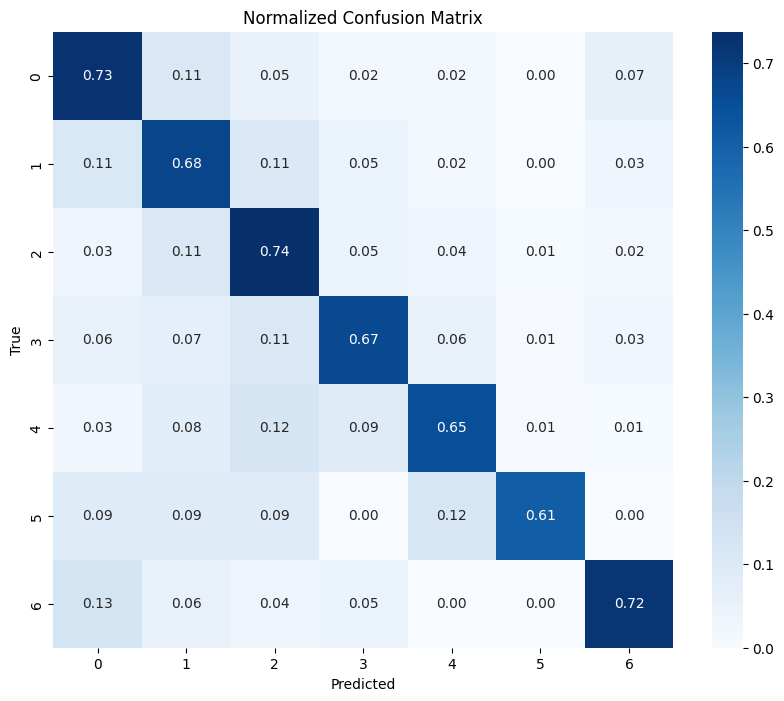

In [ ]:
# Generar matriz de confusión solo para la última época
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Función para normalizar la matriz de confusión
def normalize_confusion_matrix(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = normalize_confusion_matrix(cm)
classes = [str(i) for i in range(7)]  # Asumiendo 7 clases

# Plot de la matriz de confusión normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


Text(0, 0.5, 'Error')

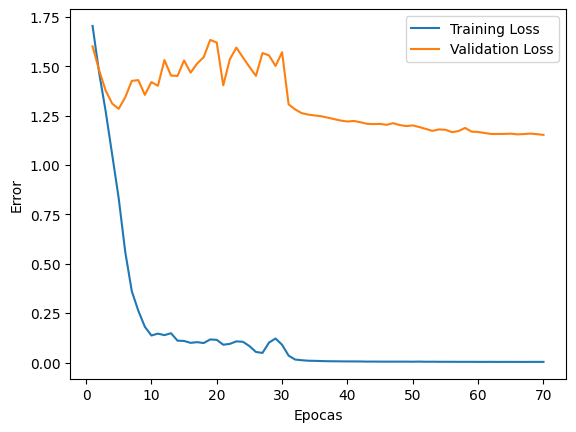

In [ ]:
import matplotlib.pyplot as plt

#Representación de los resultados
lista = list(range(1, len(loss_validation) + 1))
plt.plot(lista, loss_train, lista , loss_validation)
plt.legend(('Training Loss', 'Validation Loss'))

# Añadir etiquetas a los ejes
plt.xlabel('Epocas')
plt.ylabel('Error')



Text(0, 0.5, 'Accuracy')

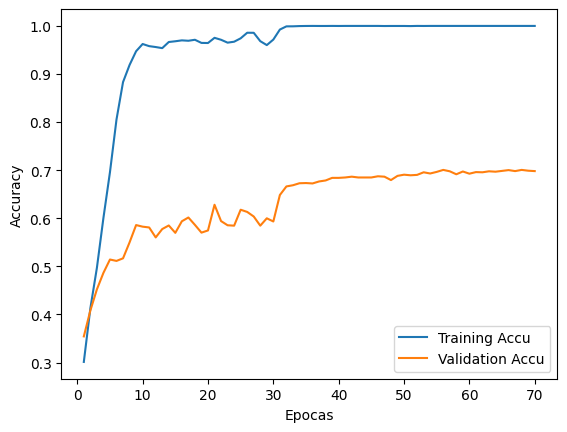

In [ ]:
#Representación de los resultados
lista = list(range(1, len(accu_validation) + 1))
plt.plot(lista, accu_train, lista , accu_validation)
plt.legend(('Training Accu', 'Validation Accu'))

# Añadir etiquetas a los ejes
plt.xlabel('Epocas')
plt.ylabel('Accuracy')

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7']
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.70      0.73      0.72       445
     class 2       0.69      0.68      0.69       564
     class 3       0.71      0.74      0.72       553
     class 4       0.72      0.67      0.69       383
     class 5       0.73      0.65      0.69       280
     class 6       0.62      0.61      0.62        33
     class 7       0.61      0.72      0.66       157

    accuracy                           0.70      2415
   macro avg       0.68      0.68      0.68      2415
weighted avg       0.70      0.70      0.70      2415



In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
print(f'Balanced Accuracy: {balanced_accuracy:.2f}')

Balanced Accuracy: 0.68
